In [1]:
from datetime import datetime
import os, pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from torchinfo import summary

In [2]:
dataset_path = os.path.realpath('D:\\Python\\DL_test\\datasets')


training_data = datasets.MNIST(
    root=dataset_path,
    train=True,
    download=True,
    transform=ToTensor(),
)
test_data = datasets.MNIST(
    root=dataset_path,
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in train_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape, X.dtype)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28]) torch.float32
Shape of y:  torch.Size([64]) torch.int64


In [3]:
class TestNN(nn.Module):
    def __init__(self, layers_dict):
        super().__init__()
        self.layers_dict_in = layers_dict
        self.layers_dict = nn.ModuleDict({name: value["fun"](*value["dims"], name) 
                                          for name, value in self.layers_dict_in.items()})
        self.historique = pd.DataFrame()
            
        return
        
    def forward(self, x):
        for _, layer in self.layers_dict.items():
            x = layer(x)
        return x


In [5]:
class ResBlock(nn.Module):
    def __init__(self, dim_in, dim_inter, dim_out, nom):
        super(ResBlock, self).__init__()
        self.dim_out = dim_out
#         
        self.repeat = int(np.ceil(dim_out/dim_in))
        self.layers_dict = nn.ModuleDict({
            f"{nom}_conv2d_0": nn.Conv2d(in_channels=dim_in, out_channels=dim_inter, kernel_size=3, 
                      stride=1, padding=1, dilation=1, groups=1, bias=True, 
                      padding_mode='zeros'), 
            f"{nom}_activation": nn.LeakyReLU(negative_slope=0.2, inplace=False),
            f"{nom}_conv2d_1": nn.Conv2d(in_channels=dim_inter, out_channels=dim_out, kernel_size=3, 
                      stride=1, padding=1, dilation=1, groups=1, bias=True, 
                      padding_mode='zeros'), 
            })

        return
    
    def forward(self, x):
        input = torch.tile(x=x, dims=(1, self.repeat, 1, 1))
        input = input[:, :self.dim_out, :, :]
        for _, layer in self.layers_dict.items():
#             print(f"x.shape : {x.shape}")
            x = layer(x)
#         print(f"input.shape : {input.shape}")
#         print(f"x.shape : {x.shape}")
        x = (input + x)
        return x


class DenseBlock(nn.Module):
    def __init__(self, dim_in, dim_out, nom):
        super(DenseBlock, self).__init__()
        self.layers_dict = nn.ModuleDict({
            f"{nom}_Flatten": nn.Flatten(), 
            f"{nom}_Dense": nn.Linear(dim_in, dim_out),
            })

        return
    
    def forward(self, x):
        for _, layer in self.layers_dict.items():
#             print(f"x.shape : {x.shape}")
            x = layer(x)
        x = nn.functional.log_softmax(x, dim=1)
        return x

    
class DownscaleBlock(nn.Module):
    def __init__(self, nom):
        super(DownscaleBlock, self).__init__()
        self.layers_dict = nn.ModuleDict({
            f"{nom}_MaxPool2d": nn.MaxPool2d(kernel_size=2, stride=2, 
                                  padding=0, dilation=1),
            })
        return
    
    def forward(self, x):
        for _, layer in self.layers_dict.items():
            x = layer(x)
            return x

In [4]:
class ModelsMgmt():
    def load(self, model, device, path, model_name):

        try:
            with open(os.path.join(path, f"{model_name}_layers_dict_in.pk"), "rb") as f:
                layers_dict_in = pickle.load(f)
        except:
            print('unable to load layers_dict')

        model.__init__(layers_dict_in)
        model.load_state_dict(torch.load(os.path.join(path, f"{model_name}_params.pt")))
        
        try:
            model.historique = pd.read_excel(os.path.join(path, f"{model_name}_historique.xlsx"), index_col=0)
        except:
            print('unable to load historique')
            
        model.to(device)
        
        return
    
    def save(self, model, path, model_name):
        
        if not os.path.exists(path):
            os.makedirs(path)
        with open(os.path.join(path, f"{model_name}_layers_dict_in.pk"), "wb") as f:
            pickle.dump(model.layers_dict_in, f)      
            
        torch.save(model.state_dict(), os.path.join(path, f"{model_name}_params.pt"))
        
        if len(model.historique)!=0:
            model.historique.to_excel(os.path.join(path, f"{model_name}_historique.xlsx"))
        return
    
    def optimize_layers(self, model, device, tresh_prun, tresh_add, flatten_size):
        '''Pseudocode : 
        On balaye les couches. 
        Lorsque s[-1]/energy est inférieur à treshold_inf, diminue la sortie de 1.
        Lorsque s[-1]/energy est supérieur à treshold_sup, on augmente la sortie de 1.
        On sauve et on actualise l'historique
        '''
        blocks = [key.split('.')[-2] for key in model.state_dict()
                 if key.split('.')[-1] == 'weight']
        if len(model.historique) == 0:
            columns = [f"{block}_s" for block in blocks]
            columns += [f"{block}_dims" for block in blocks]
            model.historique = pd.DataFrame(columns=columns).astype('object')
        curr_idx = datetime.now().strftime("%y-%m-%d-%H:%M:%S")
        model.historique.append(pd.Series(name=curr_idx, dtype='object'))
        curr_block = ""
        layer_in_block = 0
        new_state_dict = {}
        evol_dim_in=0
        for param_tensor in model.state_dict():
            if param_tensor[-6:]=="weight" :
                layer_tree = param_tensor.split(".")
                block = layer_tree[1]
                curr_layer = layer_tree[-2]
                print(f"curr_layer : {curr_layer}")
                if block == curr_block:
                    layer_in_block += 1
                else:
                    layer_in_block = 0
                    curr_block = block
                weight = model.state_dict()[param_tensor]
                u, s, vh = get_usvh(weight)
                model.historique.at[curr_idx, f"{curr_layer}_s"] = str(s.tolist())
                model.historique.at[curr_idx, f"{curr_layer}_dims"] = str(weight.shape[:2])
                if len(weight.shape)==4:
                    in_step = 1
                else:
                    in_step = flatten_size**2

                if evol_dim_in <0:
                    print(f"réduire d_in de {evol_dim_in * in_step}")
                elif evol_dim_in == 1:
                    print(f"augmenter d_in de {evol_dim_in * in_step}")
                model.layers_dict_in[block]["dims"][layer_in_block] = weight.shape[1] + in_step * evol_dim_in

                energy = torch.sum(s)
                print(f"s[-1]/energy : {s[-1]/energy}")
                if (s[-1] < tresh_prun*energy) and (curr_layer != blocks[-1]):
                    i = 1
                    while torch.sum(s[-i-1:]) < tresh_prun*energy:
                        i += 1
                    print(f"réduire d_out de {i}")
                    evol_dim_out = -i
                elif (s[-1] > tresh_add*energy) and (curr_layer != blocks[-1]):
                    print("augmenter d_out de 1")
                    evol_dim_out = 1
                else:
                    evol_dim_out = 0
                
                # update wieghts and bias
                param_bias = param_tensor[:-6]+"bias"
                bias = model.state_dict()[param_bias]
                if evol_dim_in != 0 or evol_dim_out != 0 :
                    weight, evol_dim_in, evol_dim_out = update_weight(m=weight, u=u, s=s, vh=vh, evol_dim_in=evol_dim_in * in_step, 
                                                                      evol_dim_out=evol_dim_out, device=device)
                    bias = update_bias(bias, evol_dim_out, device)
                
                    print(f"weight.shape : {weight.shape}")
                    print(f"bias.shape : {bias.shape}")
                    print(f"evol_dim_out : {evol_dim_out}")
                new_state_dict[param_tensor] = weight
                new_state_dict[param_bias] = bias
                
                model.layers_dict_in[block]["dims"][layer_in_block + 1] += evol_dim_out
                
                evol_dim_in = evol_dim_out
            else:
                if param_tensor not in new_state_dict.keys():
                    new_state_dict[param_tensor] = model.state_dict[param_tensor]


        generic_name = "tmp"
        model.layers_dict = nn.ModuleDict({name: value["fun"](*value["dims"], name) 
                                          for name, value in model.layers_dict_in.items()})
        model.load_state_dict(new_state_dict)
        self.save(model, "D:\\Python\\DL_test\\DL_tests\\bckup", f"{generic_name}")
        self.load(model, device, "D:\\Python\\DL_test\\DL_tests\\bckup", f"{generic_name}")
        print(f"layers_dict_in : {model.layers_dict_in}")

        return model

    

In [9]:
def get_usvh(m):
    if len(m.shape)==4:
        # Format d_out * d_in ou ch_out * ch_in * h * w
        # la dimension coupée doit être la première du reshape/slice
        a = m.reshape(m.shape[0], m.shape[1]*m.shape[2]*m.shape[3])
        d_in = m.shape[1]*m.shape[2]*m.shape[3]
        d_out = m.shape[0]

    elif len(m.shape)==2:
        a = m
        d_in = m.shape[1]
        d_out = m.shape[0]

    u, s, vh = torch.linalg.svd(a, full_matrices=False)
    print(f"s : {s[0]}...{s[-1]}, s.shape : {s.shape}")

    usvh = u @ torch.diag(s) @ vh

    if len(m.shape)==4:
        usvh = usvh.reshape(m.shape[0], m.shape[1], m.shape[2], m.shape[3])

    return u, s, vh

def update_weight(m, u, s, vh, evol_dim_in, evol_dim_out, device):
    if len(m.shape)==4:
        step = m.shape[2]*m.shape[3]
    else:
        step = 1

    d_in = m.shape[1]
    d_out = m.shape[0]
    
    # contrôle de la taille des matrices
    # d_in : contrôle inutile car d_out contrôlé au layer précédent
    if d_out + evol_dim_out == 0:
        evol_dim_out = 0        
    if (d_in + evol_dim_in)*step < d_out + evol_dim_out:
        evol_dim_out = (d_in + evol_dim_in)*step - d_out
        
    # modif des poids
    if evol_dim_in < 0:
        vh = vh[:, :evol_dim_in*step]
    elif evol_dim_in > 0:
        vh_ = torch.randn(d_out, (d_in + evol_dim_in) * step, device=device)/(d_in + evol_dim_in)
        vh_[:d_out, :d_in*step] = vh
        vh = vh_
        
    if evol_dim_out < 0:
        u = u[:evol_dim_out, :evol_dim_out]
        s = s[:evol_dim_out]
        vh = vh[:evol_dim_out, :]
    elif evol_dim_out > 0:
        u_ = torch.randn(d_out + evol_dim_out, d_out + evol_dim_out, device=device)/(d_out + evol_dim_out)
        u_[:d_out, :d_out] = u
        u = u_
        s_ = torch.randn(d_out + evol_dim_out, device=device)/(d_out + evol_dim_out)
        s_[:d_out] = s      
        s = s_
        vh_ = torch.randn(d_out + evol_dim_out, (d_in + evol_dim_in) * step, device=device)/(d_in + evol_dim_in)
        vh_[:d_out, :(d_in + evol_dim_in) * step] = vh
        vh = vh_

    usvh = u @ torch.diag(s) @ vh

    if len(m.shape)==4:
        usvh = usvh.reshape(m.shape[0] + evol_dim_out, m.shape[1] + evol_dim_in, m.shape[2], m.shape[3])

    return usvh, evol_dim_in, evol_dim_out
    
def update_bias(bias, evol_dim_out, device):
    if evol_dim_out < 0:
        bias = bias[:evol_dim_out]
    elif evol_dim_out > 0:
        bias_ = torch.randn(bias.shape[0] + evol_dim_out, device=device)
        bias_[:bias.shape[0]] = bias
        bias = bias_
        
    return bias
    
                

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

model_name = "20210729_MNIST_SVD"

layers_dict = {
    "ResBlock_0" : {"fun": ResBlock, "dims": [1,7,24]},
    "ResBlock_1" : {"fun": ResBlock, "dims": [24,48,72]},
    "DownscaleBlock_2" : {"fun": DownscaleBlock, "dims": []},
    "ResBlock_3" : {"fun": ResBlock, "dims": [72, 100, 120]},
    "ResBlock_4" : {"fun": ResBlock, "dims": [120, 140, 160]},
    "DownscaleBlock_5" : {"fun": DownscaleBlock, "dims": []},
    "ResBlock_6" : {"fun": ResBlock, "dims": [160, 180, 200]},
    "ResBlock_7" : {"fun": ResBlock, "dims": [200, 200, 200]},
    "DenseBlock_8" : {"fun": DenseBlock, "dims": [7*7*200, 10]},
    }
model = TestNN(layers_dict=layers_dict)
model.to(device)
print(model)

print(summary(model, input_size=X.shape, row_settings =("depth", "var_names"),depth=6))

train_losses = []
test_losses = []


Using cuda device
TestNN(
  (layers_dict): ModuleDict(
    (ResBlock_0): ResBlock(
      (layers_dict): ModuleDict(
        (ResBlock_0_conv2d_0): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (ResBlock_0_activation): LeakyReLU(negative_slope=0.2)
        (ResBlock_0_conv2d_1): Conv2d(7, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (ResBlock_1): ResBlock(
      (layers_dict): ModuleDict(
        (ResBlock_1_conv2d_0): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (ResBlock_1_activation): LeakyReLU(negative_slope=0.2)
        (ResBlock_1_conv2d_1): Conv2d(48, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (DownscaleBlock_2): DownscaleBlock(
      (layers_dict): ModuleDict(
        (DownscaleBlock_2_MaxPool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (ResBlock_3): ResBlock(
      (layers_dict): ModuleDict(
        (ResBlock_3_con

2021-07-29 22:56:27.525765 : Epoch : 0
training set accuracy : 0.988
testing set accuracy : 0.9852
2021-07-29 22:56:54.023670 : Epoch : 1
training set accuracy : 0.9872833333333333
testing set accuracy : 0.9874
2021-07-29 22:57:20.836691
optimizing layers...
curr_layer : ResBlock_0_conv2d_0
s : 0.0612044557929039...0.0018406923627480865, s.shape : torch.Size([3])
s[-1]/energy : 0.024055471643805504
augmenter d_out de 1
weight.shape : torch.Size([4, 1, 3, 3])
bias.shape : torch.Size([4])
evol_dim_out : 1
curr_layer : ResBlock_0_conv2d_1
s : 0.07867541164159775...0.0003345362492837012, s.shape : torch.Size([4])
augmenter d_in de 1
s[-1]/energy : 0.004103615880012512
réduire d_out de 1
weight.shape : torch.Size([3, 4, 3, 3])
bias.shape : torch.Size([3])
evol_dim_out : -1
curr_layer : ResBlock_1_conv2d_0
s : 1.0830414295196533...0.021002979949116707, s.shape : torch.Size([7])
réduire d_in de -1
s[-1]/energy : 0.014712238684296608
augmenter d_out de 1
weight.shape : torch.Size([8, 3, 3, 3])

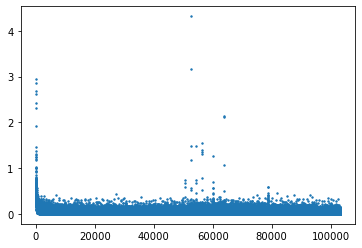

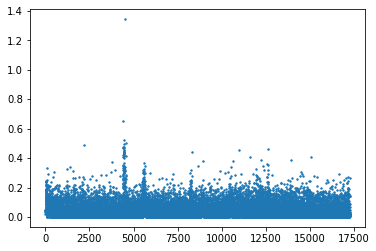

In [22]:
nb_epochs = 10
prev_epoch = 100
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-2)
criterion = nn.NLLLoss()
try:
    len(test_losses)
    len(train_losses)
except:
    train_losses = []
    test_losses = []

model.to(device)
for epoch in range(nb_epochs):
    print(f"{datetime.now()} : Epoch : {epoch}")
    
    model.train()
    correct_train, target_count = 0, 0
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad() # Clear gradients
        output = model(x) # Forward pass
        loss = criterion(output, y) # Calculate loss

        train_losses.append(loss.item())

        loss.backward() # Backward pass
        optimizer.step() # Optimize weights
        
        # accuracy
        _, predicted = torch.max(output.data, 1)
        target_count += y.size(0)
        correct_train += (y == predicted).sum().item()
    train_acc = (correct_train) / target_count
    print(f"training set accuracy : {train_acc}")
        
    model.eval()
    correct_train, target_count = 0, 0
    for x, y in test_dataloader:
        x, y = x.to(device), y.to(device)
        output = model(x) # Forward pass
        loss = criterion(output, y) # Calculate loss

        test_losses.append(loss.item())
        # accuracy
        _, predicted = torch.max(output.data, 1)
        target_count += y.size(0)
        correct_train += (y == predicted).sum().item()
    test_acc = (correct_train) / target_count
    print(f"testing set accuracy : {test_acc}")
    
    if (epoch + prev_epoch) % 2 == 1:
        print(datetime.now())
        print("optimizing layers...")    
        model = ModelsMgmt().optimize_layers(model, tresh_prun=5e-3, tresh_add=1e-2, flatten_size=7, device=device)
        iter = epoch + prev_epoch
        step = f"{iter}_iters_optim"
        ModelsMgmt().save(model, "D:\\Python\\DL_test\\DL_tests\\bckup", f"{model_name}_{step}")
        optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-2)

print(summary(model, input_size=X.shape, row_settings =("depth", "var_names"),depth=6))

    
plt.figure()
plt.scatter([x for x in range(len(train_losses))], train_losses, s=2)
plt.show()

plt.figure()
plt.scatter([x for x in range(len(test_losses))], test_losses, s=2)
plt.show()

In [ ]:
# Récupérer un backup
print(datetime.now())
ModelsMgmt().optimize_layers(model, tresh_prun=6e-3, tresh_add=1.8e-2, flatten_size=7, device=device)
print(summary(model, input_size=X.shape, row_settings =("depth", "var_names"),depth=6))


generic_name = "20210729_MNIST_SVD"
step = "71_iters_optim"

ModelsMgmt().load(model, device, "D:\\Python\\DL_test\\DL_tests\\bckup", f"{generic_name}_{step}")

In [155]:
print(f"Using {device} device")

Using cuda device


In [59]:
%whos

Variable           Type          Data/Info
------------------------------------------
DataLoader         type          <class 'torch.utils.data.dataloader.DataLoader'>
DenseBlock         type          <class '__main__.DenseBlock'>
DownscaleBlock     type          <class '__main__.DownscaleBlock'>
F                  module        <module 'torch.nn.functio<...>orch\\nn\\functional.py'>
ModelsMgmt         type          <class '__main__.ModelsMgmt'>
ResBlock           type          <class '__main__.ResBlock'>
TestNN             type          <class '__main__.TestNN'>
ToTensor           type          <class 'torchvision.trans<...>rms.transforms.ToTensor'>
X                  Tensor        tensor([[[[0., 0., 0.,  .<...>0.,  ..., 0., 0., 0.]]]])
batch_size         int           64
correct_train      int           9839
criterion          NLLLoss       NLLLoss()
dataset_path       str           D:\Python\DL_test\datasets
datasets           module        <module 'torchvision.data<...>\\datasets\\